**Bone Segmentation Model for Knee Joint Lateral X-Ray (Main Jupyter Notebook)**


Version 1

By Lu Yik Ho

**Step 1.3: Required Python Modules**

In [1]:
# Import all required modules.

# Run this code box once to ensure all modules are installed.

import torch

gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
torch.cuda.get_device_name(0)

import pydicom
import os
import glob
import numpy as np
import json
import torch.utils.data
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import ultralytics
import cv2
os.environ['YOLO_VERBOSE'] = 'false'
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import yaml

print("All modules imported!")

Is the GPU available? True
All modules imported!


**Step 2.1: Retrieving and Flipping Images from DICOM Files**

In [ ]:
# Retrieves PNG images from DICOM files

from BoneSegmentationLateral_ImageProcessing import dicom_to_png

# Input path to DICOM Files
dicom_files_lateralL = glob.glob("./DICOM Files/**/**/**/LLAT/**")
dicom_files_lateralR = glob.glob("./DICOM Files/**/**/**/RLAT/**")

count = 0 

# Convert all DICOM files to PNG
for file in dicom_files_lateralL:
    if not file.endswith(".png") and not file.endswith(".json") and not file.endswith(".txt"):
        dicom_to_png(file)
        count = count + 1

print("LL Images: {}".format(count))
count = 0 

# Convert all DICOM files to PNG
for file in dicom_files_lateralR:
    if not file.endswith(".png") and not file.endswith(".json") and not file.endswith(".txt"):
        dicom_to_png(file)
        count = count + 1

print("RL Images: {}".format(count))

In [ ]:
# Flips right knee images horizontally

from BoneSegmentationLateral_ImageProcessing import flip_png

# Input target PNG files
png_files = glob.glob("./DICOM Files/**/**/**/RLAT/**.png")

# Flip all PNG files
for file in png_files:
    
    # Prevents flipping twice
    if not file.endswith("_F.png") and not file.endswith("_N.png"):
      flip_png(file)

**Step 2.2: Cropping Images into Squares**

In [ ]:
from BoneSegmentationLateral_ImageProcessing import predict_img, calculatePredictBox, calculateSquareBox, crop_img

# Load target model
model = YOLO("./SquareCroppingModel.pt")

# Input target PNG files
img_files_L = glob.glob("./DICOM Files/**/**/**/LLAT/**.png")
img_files_R = glob.glob("./DICOM Files/**/**/**/RLAT/**_F.png")

# Input output directory
out_dir = "./Square Images"

# The part of the bounding box to be changed to create a square bounding box. Enter "None" to bypass.
square_from = "Bottom"

for file in img_files_L:
    if file.endswith(".png"):
        result = predict_img(model, file)

        predict_box = calculatePredictBox(result)

        adjust_box = calculateSquareBox(predict_box, square_from)

        crop_img(file, out_dir, float(adjust_box["x_min"]), float(adjust_box["y_min"]), float(adjust_box["box_width"]), float(adjust_box["box_height"]))

for file in img_files_R:
    if file.endswith("_F.png"):
        result = predict_img(model, file)

        predict_box = calculatePredictBox(result)

        adjust_box = calculateSquareBox(predict_box, square_from)

        crop_img(file, out_dir, float(adjust_box["x_min"]), float(adjust_box["y_min"]), float(adjust_box["box_width"]), float(adjust_box["box_height"]))   

**Step 2.3: Processing Square Images**


In [ ]:
# Normalise output images

from BoneSegmentationLateral_ImageProcessing import normal_img

# Input target PNG files
img_files = glob.glob("./Square Images/**")

# Input output directory
output_dir = "./Normal Images"

for file in img_files:
    if file.endswith(".png"):
      normal_img(file, True, output_dir)

In [6]:
# Apply CLAHE Normalisation on output images

from BoneSegmentationLateral_ImageProcessing import apply_clahe

# Input target PNG files
img_files = glob.glob("./Normal Images/**")

# Input output directory
output_dir = "./Training Images"

for file in img_files:
    if file.endswith("_N.png"):
      apply_clahe(file, output_dir)

**Step 4.2: Creating YOLO Dataset**

In [ ]:
# Splits the current data from directories into training and testing data, and saves data to YOLO required directory format

# Splits each class into its separate image and text file.

from BoneSegmentationLateral_TrainYOLOModel import YOLOTTSplit_splitClass

# Input and Output Directories
json_files = glob.glob("./Training Images/**.json")
img_dir = "./Training Images"
target_dir = "./YOLO Dataset"

# Names of classes
label_names = ["Patella", "Femur", "Tibia"]

# Percentage of data to be used at testing
test_section = 0.20

YOLOTTSplit_splitClass(json_files, img_dir, target_dir, label_names, test_section = 0.20)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


**Step 4.3: Creating YOLO YAML file**

In [9]:
# Writing the required .yaml file required for YOLO

from BoneSegmentationLateral_TrainYOLOModel import createYaml

# Path to YOLO dataset
path = "./YOLO Dataset"

# Names of classes
names = ["Patella", "Femur", "Tibia"]

# Relative path to validation images
train = "images/train"

# Relative path to validation images
val = "images/val"

# Number of classses
nc = 3 

createYaml(path, train, val, nc, names, path)

**Step 5.1 / 5.2: Fine-Tuning New / Pre-Trained Model**

In [ ]:
# Trains a YOLO model with the dataset. 

# Please make sure the .yaml file is directly under this directory!

from BoneSegmentationLateral_TrainYOLOModel import trainModel    

# The directory to your YOLO dataset
dataset_dir = "./YOLO Dataset"

# Path to your model. Put None if training brand new model
model_path = None

# Set number of epochs
epoch_num = 50

# Toggle simplified output
simple_output = True

# 1 simple output per number of epochs
simple_output_per_epoch = 10


trainModel(dataset_dir, model_path, epoch_num, simple_output, simple_output_per_epoch)


**Step 5.3: Interpreting Training Results**

In [ ]:
from BoneSegmentationLateral_TrainYOLOModel import extraResultPlots

json_file = "./YOLO Dataset/output_data.json"

extraResultPlots(json_file)

**Step 6.1: Running Inference**


0: 640x640 1 Patella, 3.2ms
1: 640x640 1 Patella, 3.2ms
Speed: 2.0ms preprocess, 3.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Femur, 3.0ms
1: 640x640 1 Femur, 3.0ms
Speed: 2.1ms preprocess, 3.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Tibia, 3.3ms
1: 640x640 1 Tibia, 3.3ms
Speed: 2.2ms preprocess, 3.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


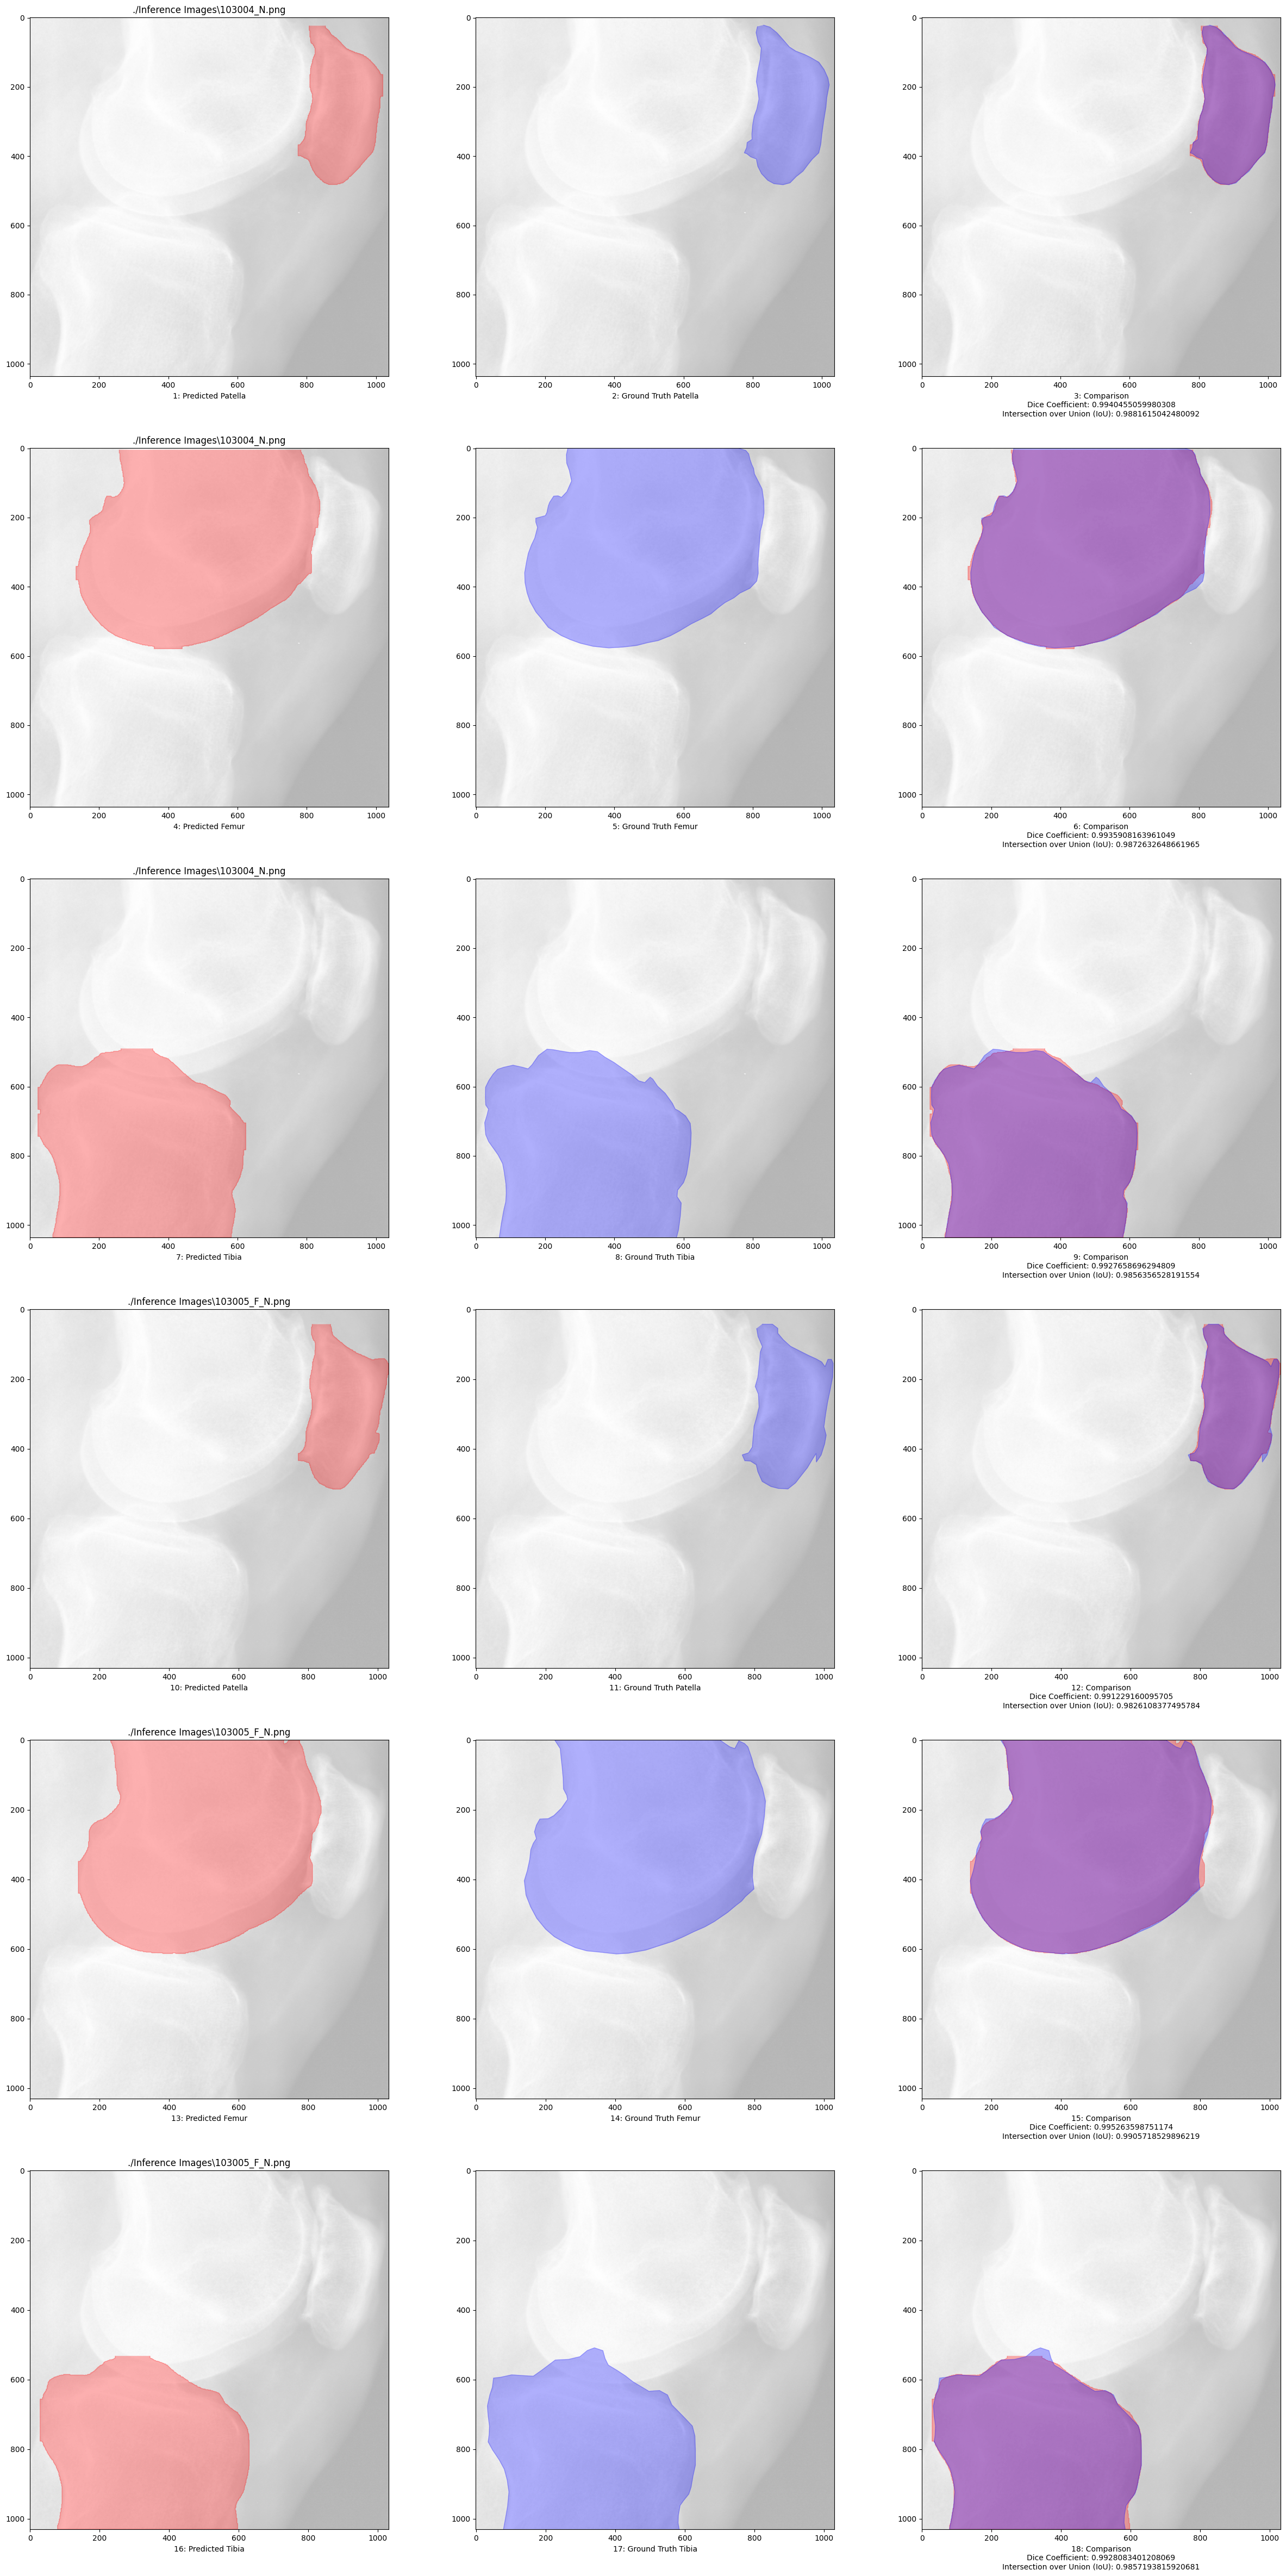

Inference check complete!
Number of Images: 6

Highest IoU (Intersection over Union): 0.9905718529896219
Lowest IoU (Intersection over Union): 0.9826108377495784
Average IoU (Intersection over Union): 0.9866604157107716
mAP50: 1.0
mAP50-95: 1.0
Highest Dice Coefficient: 0.995263598751174
Lowest Dice Coefficient: 0.991229160095705
Average Dice Coefficient: 0.9932838818318838


In [5]:
from BoneSegmentationLateral_TrainYOLOModel import segmentation_inference

# Load trained model 
model = YOLO("./runs/segment/500FullTrain/weights/best.pt")

# The directory to your images
img_dir = "./Inference Images"

# The directory to your LabelMe JSON files
json_dir = "./Inference Images"

# The directory to output mask images of predictions.
mask_output_dir = "./Inference Masks/Prediction"

# The directory to output mask images of the ground truth.
truth_output_dir = "./Inference Masks/Ground Truth"

# Names of classes
label_names = ["Patella", "Femur", "Tibia"]

# Length of each square plot in inches
plot_size = 10



segmentation_inference(model, img_dir, json_dir, mask_output_dir, truth_output_dir, label_names, plot_size = 10)


**Step 7.1: Creating Mask Images**

In [ ]:
from BoneSegmentationLateral_TrainYOLOModel import predict_imgs


# Load trained model 
model = YOLO("./runs/segment/DemoModel/weights/best.pt")

# Input target PNG files
img_files = glob.glob("./Images for Processing/**.png")

# The directory to output mask images of predictions.
mask_output_dir = "./Processing Image Masks"

# Names of classes
label_names = ["Patella", "Femur", "Tibia"]

predict_imgs(model, img_files, mask_output_dir, label_names)

ValueError: need at least one array to stack